In [2]:
import numpy as np # We'll be storing our data as numpy arrays
import os # For handling directories
from PIL import Image # For handling the images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # Plotting

In [3]:
import warnings
warnings.filterwarnings('ignore')

import keras
import matplotlib.pyplot as plt # for plotting
import os # provides a way of using operating system dependent functionality
import cv2 #Image handling library
import numpy as np
import keras.backend as K
from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
from sklearn.datasets import make_multilabel_classification
# Import of keras model and hidden layers for our convolutional network
from keras.layers import Conv2D, Activation, MaxPool2D, Dense, Flatten, Dropout

In [4]:
CATEGORIES = ["01_palm", '02_l','03_fist','04_fist_moved','05_thumb','06_index','07_ok','08_palm_moved','09_c','10_down']
IMG_SIZE = 50

# paths for dataset
data_path = "../input/dataset/leapGestRecog/leapGestRecog"

In [5]:
# Loading the images and their class(0 - 9)
image_data = []
for dr in os.listdir(data_path):
    for category in CATEGORIES:
        class_index = CATEGORIES.index(category)    
        path = os.path.join(data_path, dr, category)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                image_data.append([cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE)), class_index])
            except Exception as e:
                pass
image_data[0]

[array([[5, 4, 4, ..., 3, 4, 2],
        [5, 4, 5, ..., 3, 3, 3],
        [4, 5, 4, ..., 4, 5, 3],
        ...,
        [4, 5, 5, ..., 5, 5, 5],
        [5, 5, 6, ..., 5, 7, 4],
        [4, 7, 5, ..., 5, 4, 4]], dtype=uint8),
 0]

In [6]:
# shuffle the input data
import random
random.shuffle(image_data)

In [7]:
input_data = []
label = []
for X, y in image_data:
    input_data.append(X)
    label.append(y)
input_data[:5]

[array([[4, 3, 4, ..., 3, 3, 4],
        [4, 4, 4, ..., 3, 4, 3],
        [5, 4, 4, ..., 4, 4, 4],
        ...,
        [4, 4, 4, ..., 3, 3, 4],
        [5, 4, 4, ..., 4, 4, 4],
        [4, 3, 4, ..., 2, 4, 4]], dtype=uint8),
 array([[6, 6, 5, ..., 3, 4, 3],
        [5, 6, 5, ..., 3, 5, 5],
        [6, 5, 6, ..., 4, 4, 5],
        ...,
        [4, 5, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 3, 4, 4],
        [5, 4, 5, ..., 3, 4, 4]], dtype=uint8),
 array([[4, 5, 5, ..., 2, 4, 3],
        [4, 4, 5, ..., 4, 3, 3],
        [5, 5, 5, ..., 3, 4, 4],
        ...,
        [5, 5, 5, ..., 4, 4, 5],
        [4, 6, 5, ..., 5, 4, 4],
        [6, 5, 5, ..., 4, 4, 4]], dtype=uint8),
 array([[7, 6, 5, ..., 4, 5, 5],
        [6, 6, 7, ..., 4, 4, 5],
        [6, 8, 8, ..., 5, 4, 4],
        ...,
        [6, 6, 6, ..., 5, 5, 6],
        [6, 6, 6, ..., 4, 5, 5],
        [5, 6, 6, ..., 5, 4, 6]], dtype=uint8),
 array([[5, 5, 4, ..., 4, 3, 3],
        [5, 4, 5, ..., 3, 4, 3],
        [5, 6, 6, ..., 5, 5, 4

In [8]:
label[:10]

[7, 8, 6, 4, 3, 6, 5, 3, 7, 8]

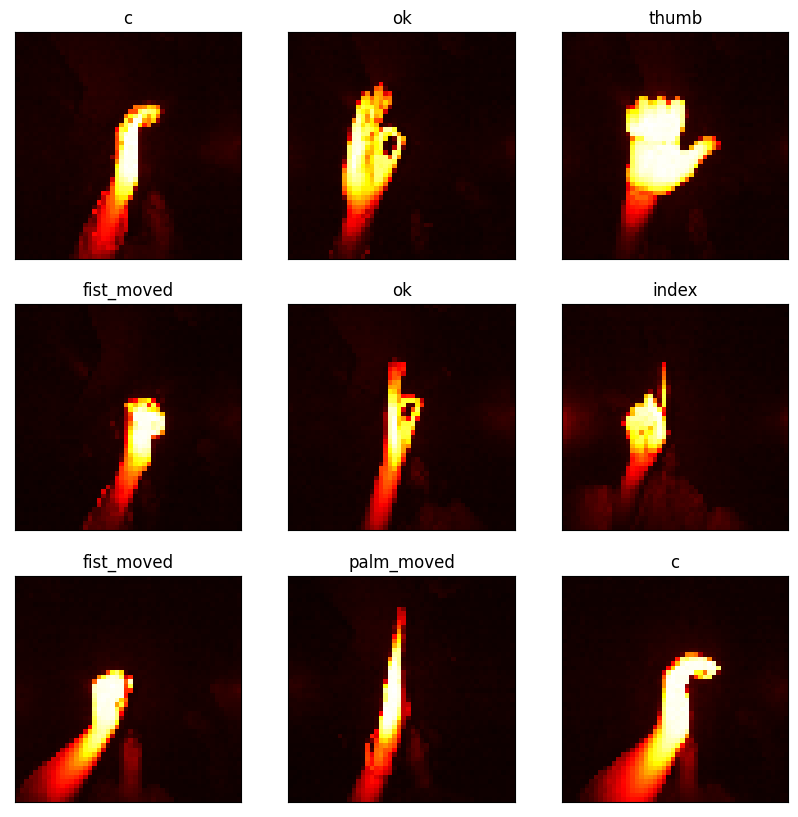

In [9]:
plt.figure(1, figsize=(10,10))
for i in range(1,10):
    plt.subplot(3,3,i)
    plt.imshow(image_data[i][0], cmap='hot')
    plt.xticks([])
    plt.yticks([])
    plt.title(CATEGORIES[label[i]][3:])
#plt.show()

In [10]:
# Normalizing the data
input_data = np.array(input_data)
label = np.array(label)
input_data = input_data/255.0
input_data.shape

(20000, 50, 50)

In [11]:
from sklearn.datasets import make_multilabel_classification
X,y=make_multilabel_classification(n_samples=500,n_features=4,n_classes=2,n_labels=3,random_state=1)
X

array([[ 9., 12.,  6., 12.],
       [ 5.,  2., 12., 22.],
       [15.,  5., 12., 11.],
       ...,
       [ 5., 10., 15., 28.],
       [ 0.,  8., 16., 27.],
       [ 6.,  9., 13., 22.]])

In [14]:
X=(X-X.min())/(X.max()-X.min())
X

array([[0.20454545, 0.27272727, 0.13636364, 0.27272727],
       [0.11363636, 0.04545455, 0.27272727, 0.5       ],
       [0.34090909, 0.11363636, 0.27272727, 0.25      ],
       ...,
       [0.11363636, 0.22727273, 0.34090909, 0.63636364],
       [0.        , 0.18181818, 0.36363636, 0.61363636],
       [0.13636364, 0.20454545, 0.29545455, 0.5       ]])

In [15]:
# one hot encoding
label = keras.utils.to_categorical(label, num_classes=10,dtype='i1')
label[0]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0], dtype=int8)

In [16]:
# reshaping the data
input_data.shape = (-1, IMG_SIZE, IMG_SIZE, 1)

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_data, label, test_size = 0.10, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.10)
X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape

((16200, 50, 50, 1),
 (16200, 10),
 (2000, 50, 50, 1),
 (2000, 10),
 (1800, 50, 50, 1),
 (1800, 10))

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 2 with shape (2,) and arg 3 with shape (10,).

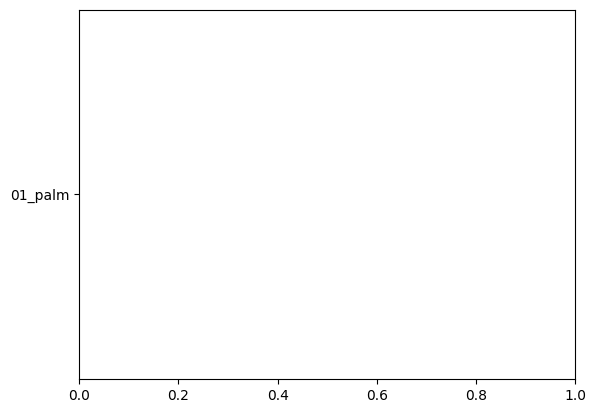

In [34]:
# classes, counts = np.unique(y_train, return_counts=True)
# plt.barh(CATEGORIES, counts)
# plt.title('Class distribution in training set')

In [18]:
model = keras.models.Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape = (IMG_SIZE, IMG_SIZE, 1)))
model.add(Activation('relu'))

model.add(Conv2D(filters = 32, kernel_size = (3,3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 64, kernel_size = (3,3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
         optimizer = 'rmsprop',
         metrics = ['accuracy'])
    

In [19]:
r = model.fit(X_train, y_train, epochs = 7, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/7
507/507 [==============================] - 38s 73ms/step - loss: 0.3160 - accuracy: 0.8952 - val_loss: 0.0505 - val_accuracy: 0.9845
Epoch 2/7
507/507 [==============================] - 37s 72ms/step - loss: 0.0190 - accuracy: 0.9946 - val_loss: 7.0385e-04 - val_accuracy: 1.0000
Epoch 3/7
507/507 [==============================] - 36s 72ms/step - loss: 0.0079 - accuracy: 0.9977 - val_loss: 1.4015e-04 - val_accuracy: 1.0000
Epoch 4/7
507/507 [==============================] - 36s 71ms/step - loss: 0.0050 - accuracy: 0.9986 - val_loss: 5.2917e-05 - val_accuracy: 1.0000
Epoch 5/7
507/507 [==============================] - 37s 72ms/step - loss: 0.0046 - accuracy: 0.9983 - val_loss: 1.4891e-05 - val_accuracy: 1.0000
Epoch 6/7
507/507 [==============================] - 41s 82ms/step - loss: 0.0011 - accuracy: 0.9996 - val_loss: 2.9658e-06 - val_accuracy: 1.0000
Epoch 7/7
507/507 [==============================] - 40s 80ms/step - loss: 0.0034 - accuracy: 0.9991 - val_loss: 1.4538e-0

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 46, 46, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 32)        0         
                                                        

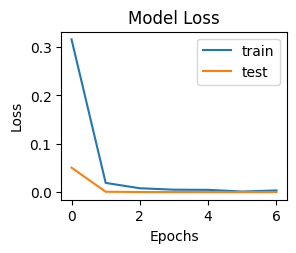

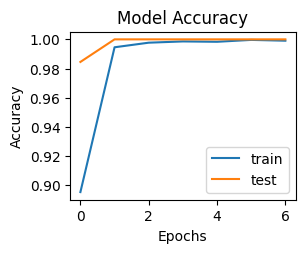

In [21]:
plt.subplot(2, 2, 1)
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()


plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [22]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print('Test accuracy: {:2.2f}%'.format(test_accuracy*100))

63/63 [==============================] - 1s 15ms/step - loss: 1.4538e-04 - accuracy: 1.0000
Test accuracy: 100.00%


In [26]:
val_loss, val_accuracy = model.evaluate(X_val, y_val)

print('Val accuracy: {:2.2f}%'.format(val_accuracy*100))

57/57 [==============================] - 1s 13ms/step - loss: 0.0036 - accuracy: 0.9994
Val accuracy: 99.94%


57/57 [==============================] - 1s 16ms/step


[]

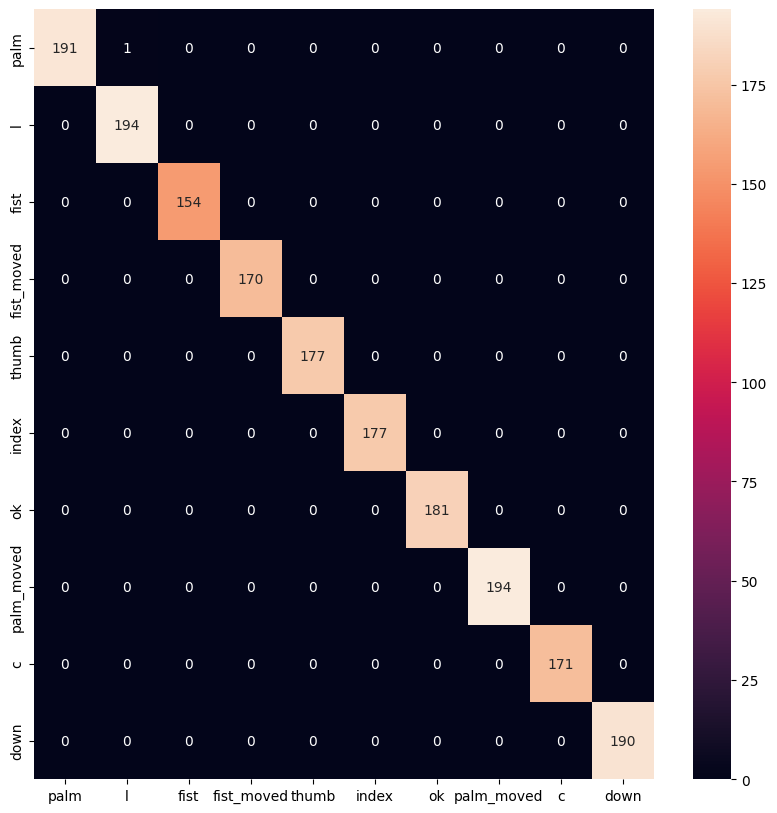

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
cat = [c[3:] for c in CATEGORIES]
plt.figure(figsize=(10,10))
cm = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(model.predict(X_val), axis=1))
sn.heatmap(cm, annot=True,fmt='d',xticklabels=cat, yticklabels=cat)
plt.plot()

In [27]:
# import numpy as np
# from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# # Contoh prediksi dan label sebenarnya
# predicted = np.array([1, 0, 1, 1, 0, 1])
# actual = np.array([1, 1, 1, 0, 1, 0])

# # Matriks kebingungan (Confusion Matrix)
# cm = confusion_matrix(actual, predicted)
# print("Confusion Matrix:")
# print(cm)

# # Akurasi
# accuracy = accuracy_score(actual, predicted)
# print("\nAccuracy:", accuracy)

# # Classification report
# report = classification_report(actual, predicted)
# print("\nClassification Report:")
# print(report)

Confusion Matrix:
[[0 2]
 [2 2]]

Accuracy: 0.3333333333333333

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.50      0.50      0.50         4

    accuracy                           0.33         6
   macro avg       0.25      0.25      0.25         6
weighted avg       0.33      0.33      0.33         6



In [23]:
# import requests
# from PIL import Image
# import cv2


# def get_img(url):
#   r = requests.get(url, stream=True)  # Download
#   img = np.array(Image.open(r.raw))  # Convert to NP Array
#   img = cv2.resize(img, (50, 50))  # Resize to match VGG16 input
#   img = img.reshape((1, 50, 50, 1))  # Use (1, 50, 50, 3) for RGB images
#   return img / 255.0

# def plot_image(predictions_array, img, true_label=None):
#     plt.grid(False)
#     plt.xticks([])
#     plt.yticks([])

#     plt.imshow(img, cmap=plt.cm.binary)
#     predicted_label = np.argmax(predictions_array)

#     accuracy = f" ({label[int(true_label)]})" if true_label != None else ""
#     if predicted_label == true_label and true_label != None:
#         color = 'blue'
#     else:
#         color = 'red'

#     plt.xlabel(f"{label[int(predicted_label)]} {100*np.max(predictions_array):2.0f}%{accuracy}",
#                color=color)

# def plot_value_array(predictions_array, true_label=None):
#     plt.grid(False)
#     plt.xticks(range(10))
#     plt.yticks([])
#     thisplot = plt.bar(range(10), predictions_array, color="#777777")
#     plt.ylim([0, 1])
#     predicted_label = np.argmax(predictions_array)

#     thisplot[predicted_label].set_color('red')
#     if true_label != None: thisplot[int(true_label)].set_color('blue')



In [24]:
# url = input("Masukan url: ")
# r = requests.get(url, stream=True)  # Download
# img = np.array(Image.open(r.raw))  # Convert to NP Array
# plt.imshow(img)
# plt.show()
# print("\n")
# img = get_img(url)
# imgnp = np.array([img])
# predict = model.predict(img)
# plt.figure(figsize=(4, 2))
# plt.subplot(1, 2, 1)
# plot_image(predict, img)
# plt.subplot(1, 2, 2)
# plot_value_array(predict[0])
# plt.tight_layout()
# plt.show()

MissingSchema: Invalid URL 'k': No scheme supplied. Perhaps you meant https://k?

In [ ]:
# from sklearn.metrics import f1_score

# y_pred = model.predict(X_test)
# y_pred = np.argmax(y_pred, axis=1)

# f = f1_score(y_train, y_pred, average='weighted')
# print("F1 Score -", f)


ValueError: in user code:

    File "C:\Users\LENOVO LEGION\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\LENOVO LEGION\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\LENOVO LEGION\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\LENOVO LEGION\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "C:\Users\LENOVO LEGION\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\LENOVO LEGION\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 50, 50, 1), found shape=(None, 10)


In [ ]:
# from sklearn.metrics import precision_score
# p=precision_score(y_train, y_pred, average='weighted')
# print("Precision Score - ",p)

ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [ ]:
# from sklearn.metrics import recall_score
# r=recall_score(y_train,y_pred,average='weighted')
# print("Recall Score - ",r)

ValueError: Found input variables with inconsistent numbers of samples: [18000, 2000]